https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor_mq.DynamicFactorMQ.html
<br>https://medium.com/@philippetousignant/dynamic-factor-models-in-python-58d2d5252640
<br>https://www.ecb.europa.eu/pub/pdf/scpwps/ecbwp1564.pdf

In [1]:
import datetime
import pandas as pd
import numpy as np
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import warnings
from statsmodels.tsa.arima.model import ARIMA

Static data

In [2]:
files = {'sources':'Data Sources.csv', 'data':'Data Cleaned.csv'}

In [3]:
train_ratio = 0.8
max_factors, max_lags = 5, 2
max_ar = 9
forecast_steps = 1

Classes and functions

In [4]:
def run_df(data, no_factors, f_lags):
    try:
        model = sm.DynamicFactorMQ(endog=data,
                                   k_endog_monthly=len([k for k,v in variables.freq.items() if v=='M']),
                                   factors=no_factors, factor_orders=f_lags,
                                   idiosyncratic_ar1=True)
        results = model.fit(maxiter=100, disp=False)
        return(results)

    except UserWarning:
        return(None)

In [5]:
def find_min_ic(models_dict):
    # info criterion type: (model specifications, info criterion value)
    ic_min = {ic:(None,float('inf')) for ic in ics}

    # k: model specifications, v: model object
    for k,v in models_dict.items():
        for ic,val in ic_min.items():
            if v[ic]<ic_min[ic][1]:
                ic_min[ic] = (k,v[ic])
    return(ic_min)

In [6]:
def compare(actual_df, predict_df):
    compare_df = pd.DataFrame(actual_df[variables.dep].dropna().values,
                              index=actual_df[variables.dep].dropna().index,
                              columns=['Actual'])

    compare_df = compare_df.merge(predict_df[variables.dep].rename(columns={variables.dep[0]:'Predicted'}),
                                  how='left', left_index=True, right_index=True)
    return(compare_df)

In [7]:
def split_train_test(data, train_prop):
    train_no_rows = round(train_prop * len(data))
    train_df = data.iloc[:train_no_rows]
    test_df = data.iloc[train_no_rows:]
    return(train_df, test_df)

In [8]:
def run_train_test(full_data, train_data, forecast_steps, factor, lag):
    fc_df = pd.DataFrame()
    model = run_df(train_data, factor, lag)
    if not model:
        return(None) # exit func if model does not converge

    for i in range(-(len(full_data)-len(train_data)), 0, forecast_steps):
        model = model.apply(endog=full_data.iloc[:i])
        forecast = model.forecast(steps=forecast_steps)
        fc_df = pd.concat([fc_df, forecast])

    export = {'model':model, 'forecasts':fc_df}

    for ic in ics:
        export[ic] = getattr(model, ic)

    return(export)

Load raw data

In [9]:
sources = pd.read_csv(files['sources'], encoding='utf-8')
ts_df = pd.read_csv(files['data'], encoding='utf-8', index_col='Period')

Explore data

In [10]:
ts_df.describe().round(3)

,"Gross Domestic Product, Year On Year Growth Rate | GDP In Chained (2015) Dollars","Food & Beverage Services Index, (2017 = 100), In Chained Volume Terms | Total","Retail Sales Index, (2017 = 100), In Chained Volume Terms | Total",Sea Cargo And Shipping Statistics (Total Cargo) | Total Container Throughput (Thousand Twenty-Foot Equivalent Units),Air Cargo Tonnage | Total Direct Tonnage (Tonne),Domestic Exports By Commodity Division | Total Domestic Exports,Merchandise Imports By Commodity Division | Total Merchandise Imports,Straits Times Index (STI),M1 Money Supply,Index Of Industrial Production (2019 = 100) | Total,...,"Business Expectations For The Services Sector - Operating Receipts Forecast For The Next Quarter, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Business Expectations For The Services Sector - General Business Outlook For The Next 6 Months, Weighted Percentages Of Up, Same, Down | Net Weighted Balance - Total Services Sector","Domestic Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Foreign Wholesale Trade Index, (2017 = 100), In Chained Volume Terms | Total","Business Receipts Index For Services Industries, (2014=100) | Total Services",Tourism Receipts By Major Components (Year-To-Date) | Tourism Receipts,Average Monthly Nominal Earnings Per Employee | Overall Economy,Job Vacancies By Industry And Occupational Group (SSIC 2020) (End Of Period) | Total,Unemployment Rate (End Of Period) | Total Unemployment Rate,Government Operating Expenditure By Sector | Total Government Operating Expenditure
count,189.000,459.000,447.000,328.000,280.000,556.000,556.000,150.000,354.000,472.000,...,113.000,113.000,109.000,109.000,81.000,60.000,85.000,128.000,121.000,63.000
mean,6.261,97.804,4.452,4.621,92795.746,9.184,8.524,3107.408,11.094,6.813,...,5.363,4.912,0.763,4.977,5.907,11916.867,3.381,7.894,3.845,8.495
std,4.600,13.287,12.800,7.997,9714.273,16.732,15.004,240.393,15.188,11.376,...,14.478,18.897,7.935,5.832,6.452,7636.981,2.449,32.329,30.128,9.805
min,-11.900,46.492,-52.310,-20.289,61659.000,-38.103,-33.492,2423.840,-11.783,-32.247,...,-53.000,-58.000,-22.732,-7.093,-13.939,425.000,-3.730,-65.247,-38.636,-6.605
25%,3.900,94.112,-2.864,1.223,87673.250,-2.356,-1.643,2995.140,4.697,-0.329,...,-1.000,-3.000,-4.226,1.135,2.601,5571.750,2.381,-10.355,-12.500,2.281
50%,6.600,100.998,2.676,5.884,92670.500,9.478,8.908,3166.620,9.790,6.673,...,8.000,7.000,0.979,4.624,5.521,11522.000,3.343,4.582,0.000,6.278
75%,9.200,106.450,9.700,9.695,99029.750,19.045,18.436,3267.702,16.051,13.631,...,13.000,18.000,5.814,9.136,9.361,17805.750,4.454,22.297,10.000,13.528
max,18.600,126.343,81.949,22.884,122889.000,72.327,57.894,3613.930,248.976,58.639,...,30.000,36.000,21.387,18.609,18.709,27689.000,10.582,119.159,150.000,50.114


/var/folders/pt/084z6q9d13g8xnn5w_dgx_dw0000gn/T/ipykernel_64397/4262810610.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


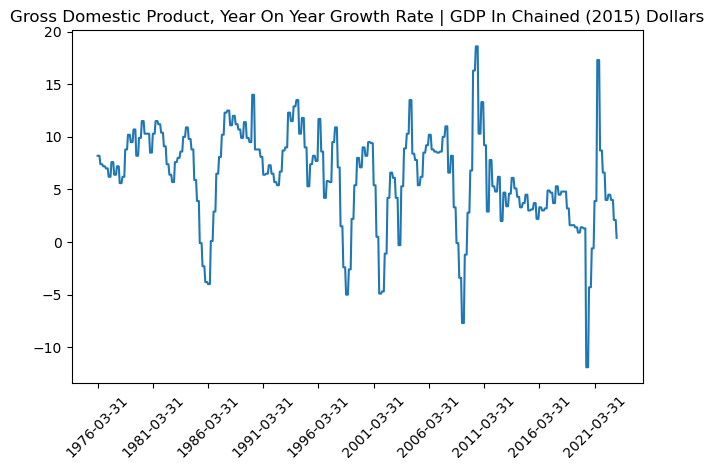

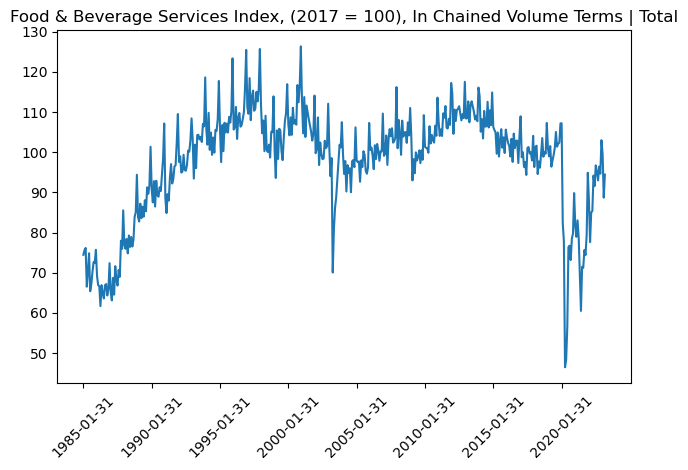

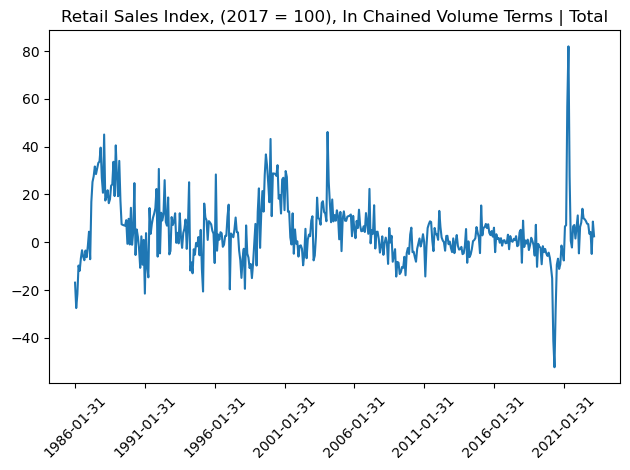

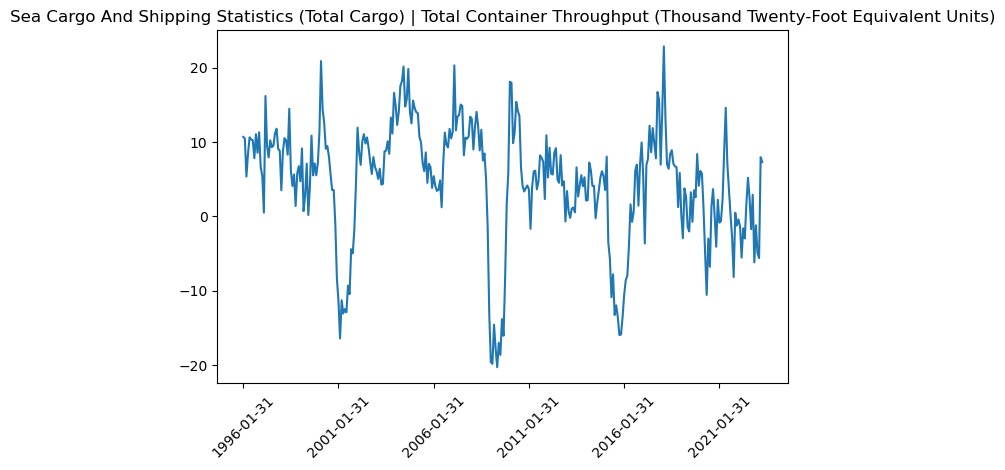

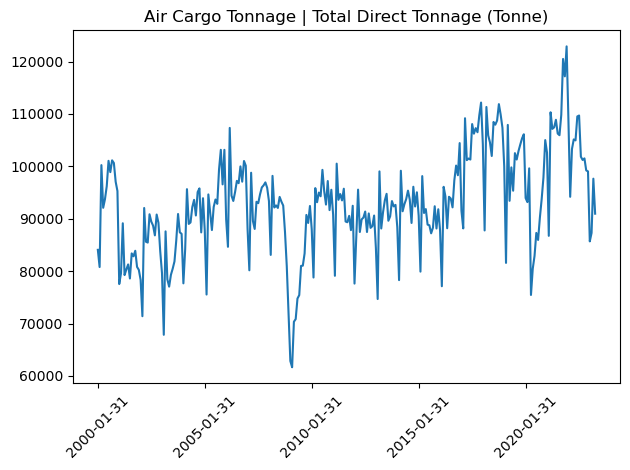

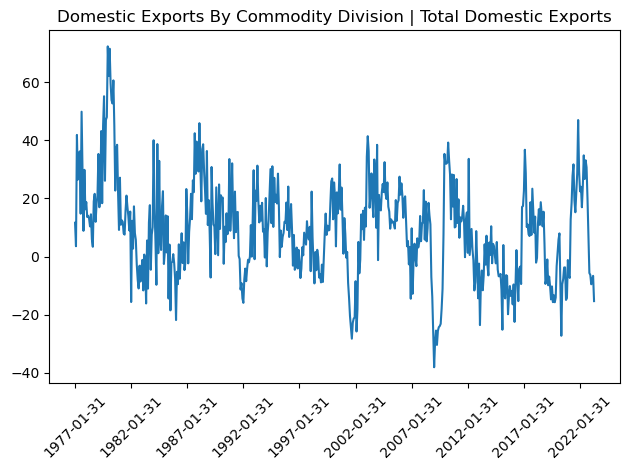

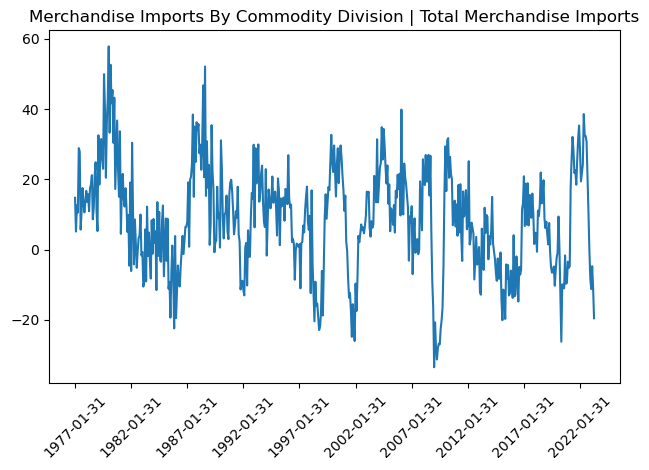

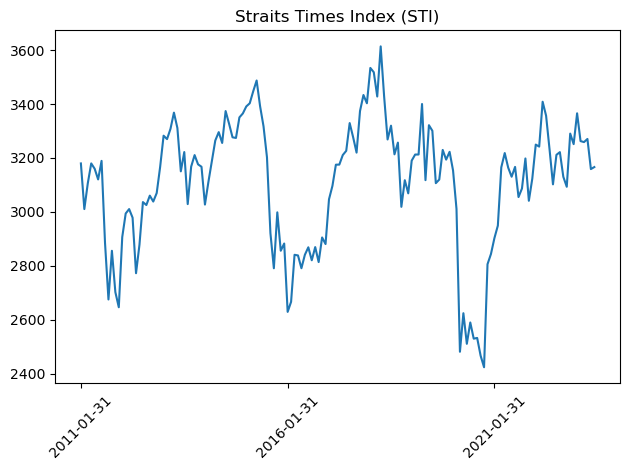

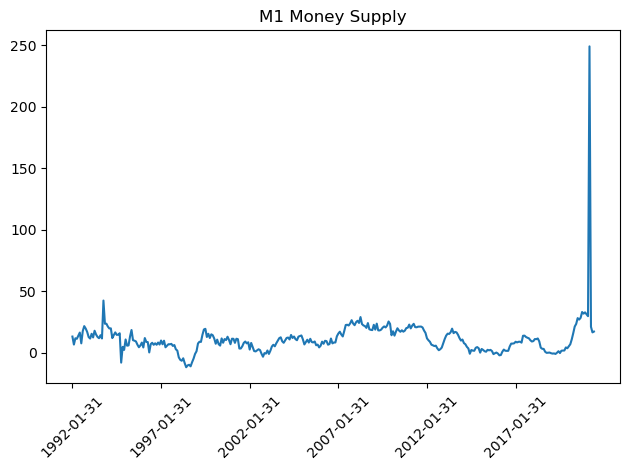

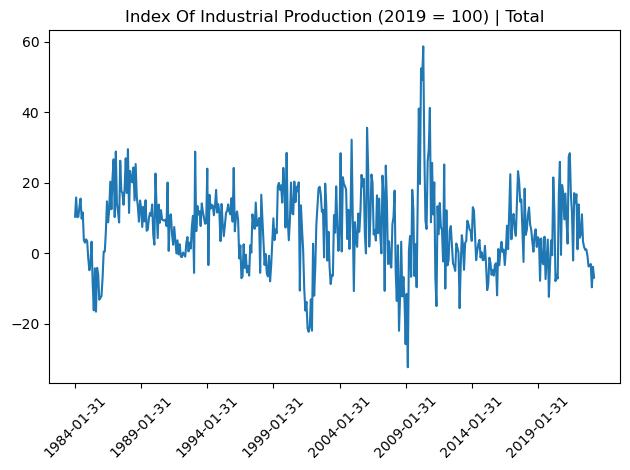

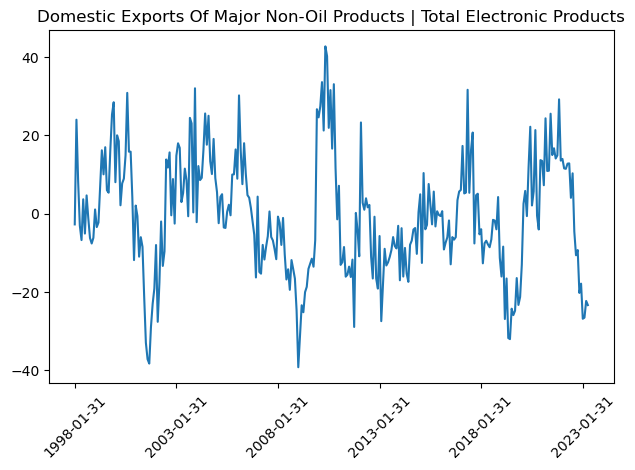

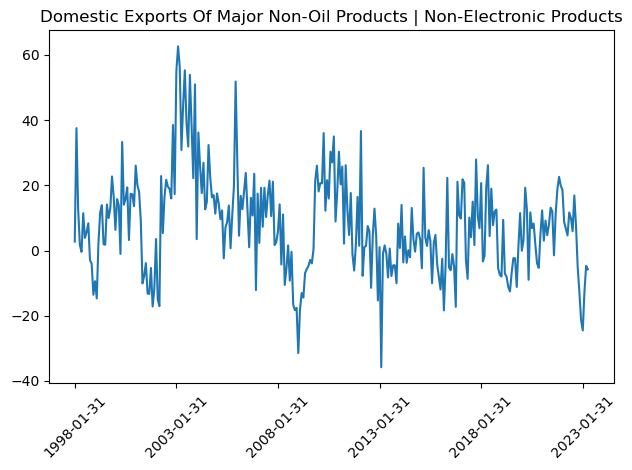

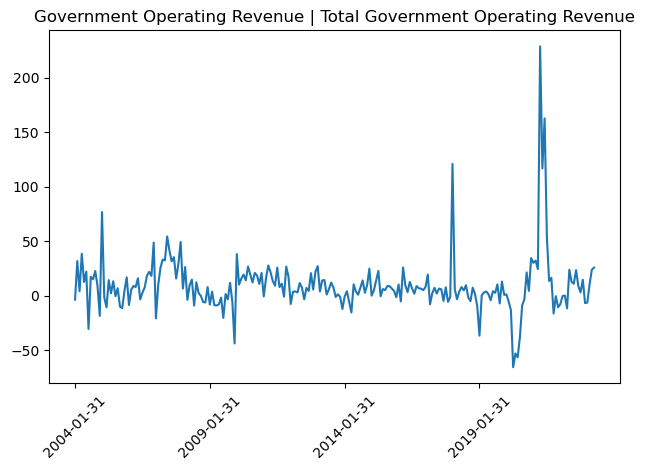

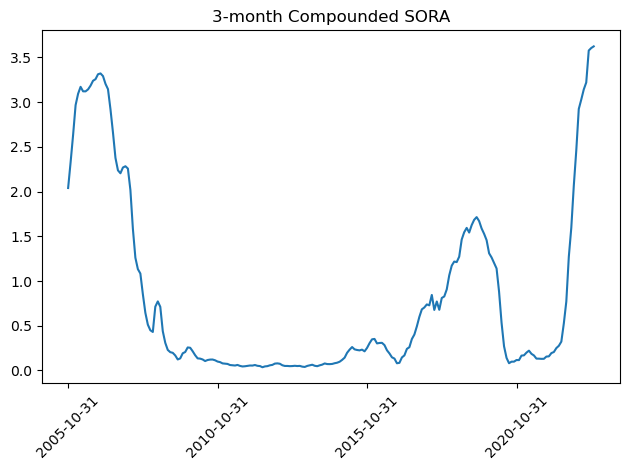

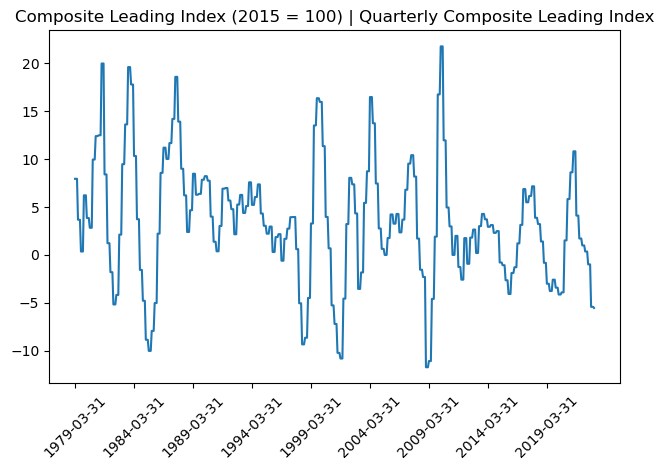

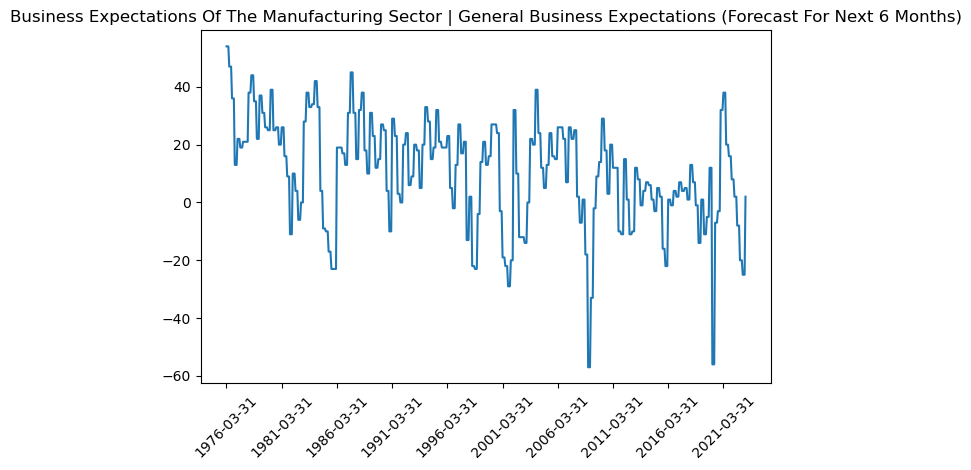

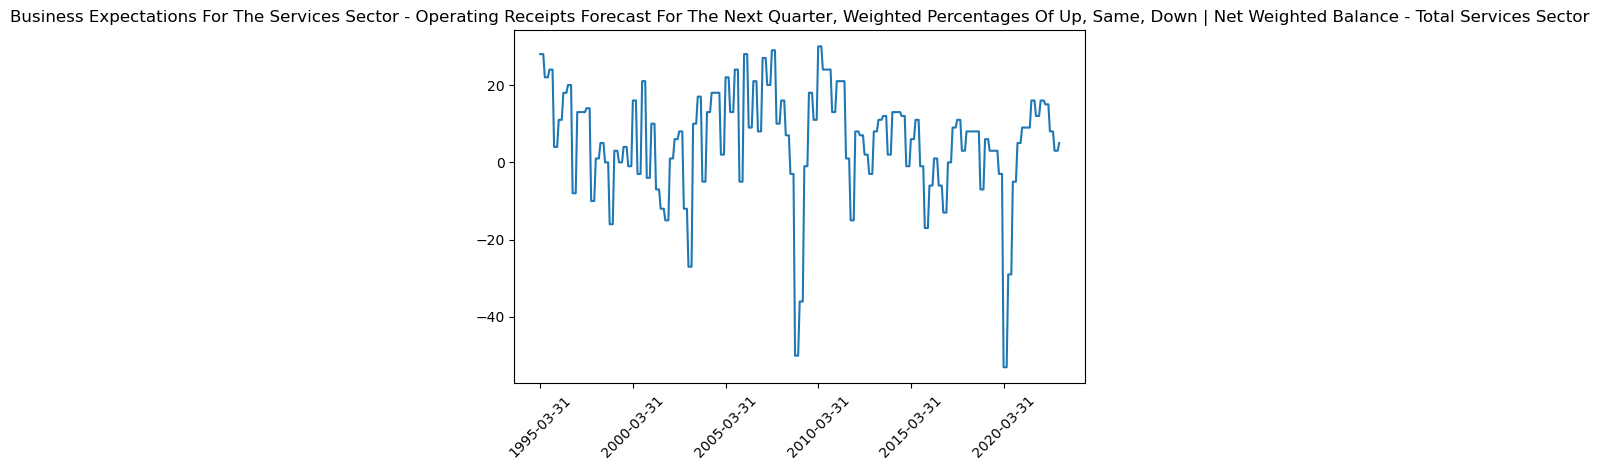

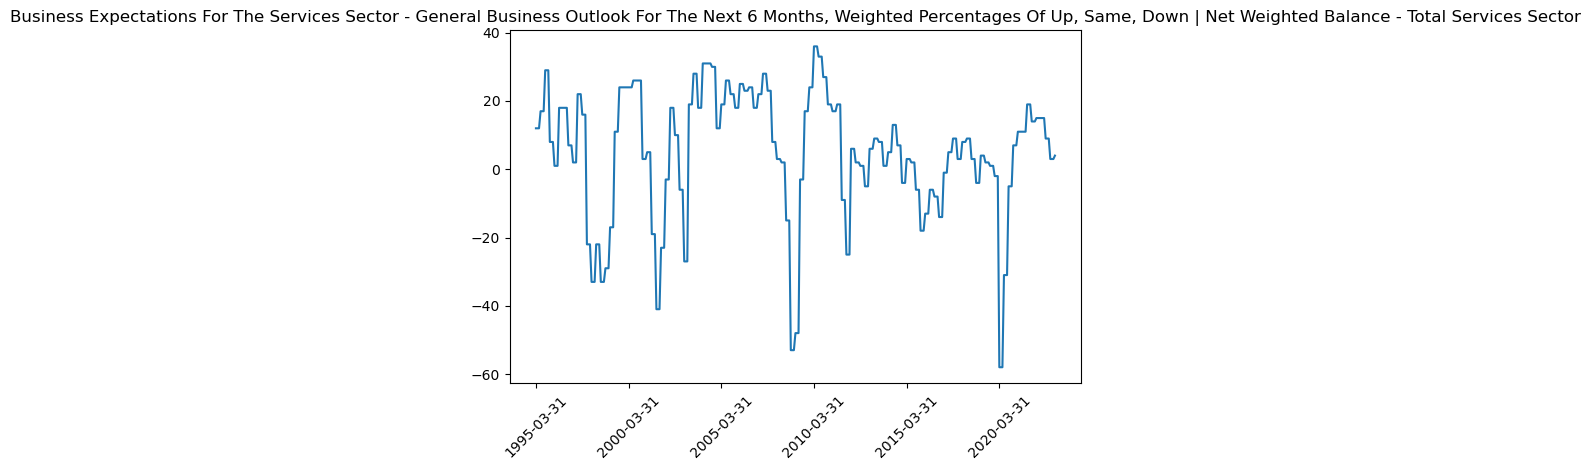

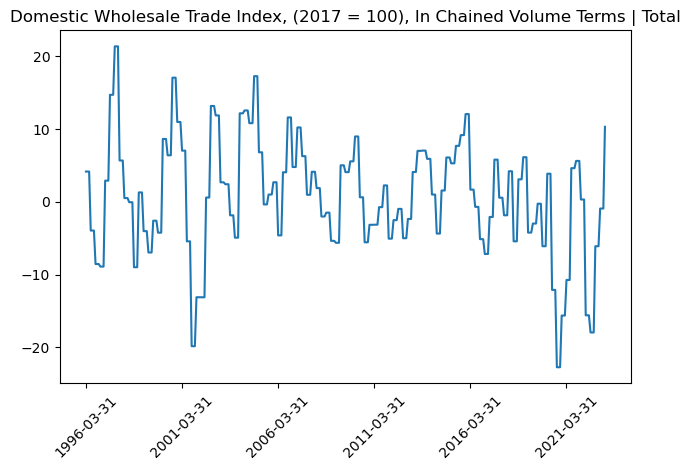

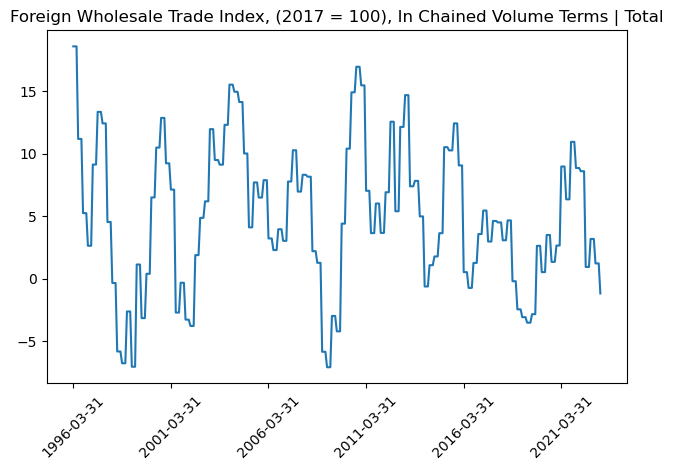

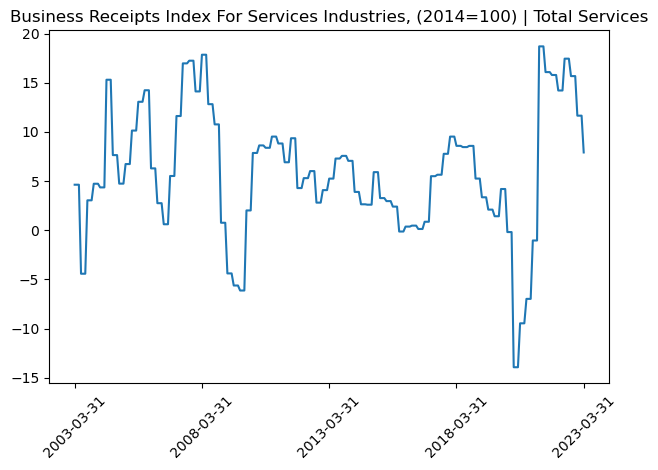

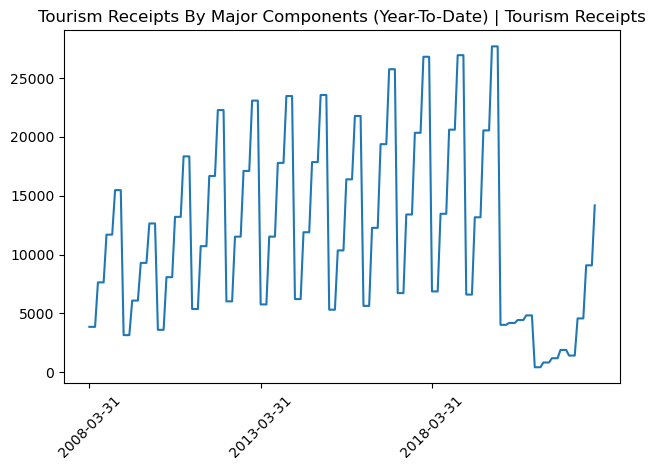

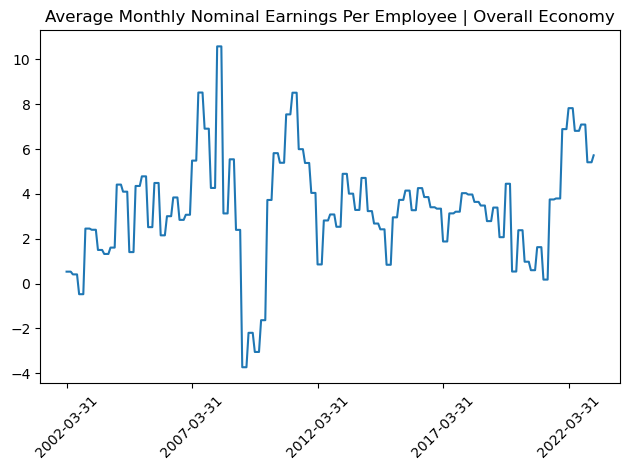

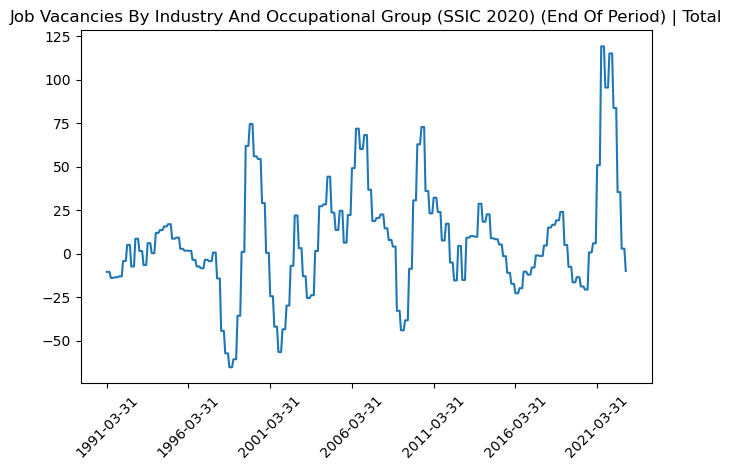

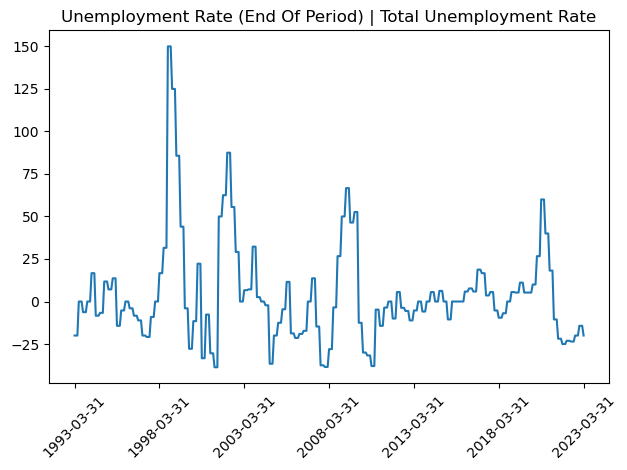

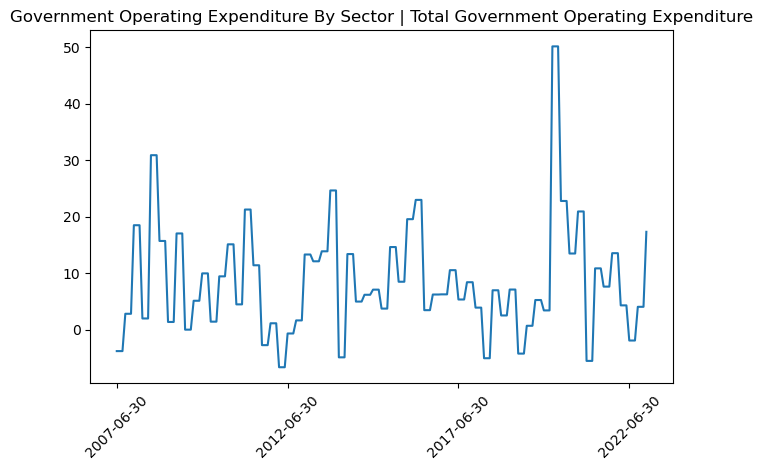

In [11]:
for i in list(ts_df):
    plt.figure()
    plt.title(i)

    # fillna because quarterly data has blanks when freq=monthly
    plt_data = ts_df[[i]].loc[ts_df[[i]].first_valid_index():ts_df[[i]].last_valid_index()].fillna(method='ffill')

    plt.plot(plt_data)
    plt.xticks(np.arange(0, len(plt_data)+1, 12*5), rotation=45)
    plt.tight_layout()

Instantiate and fit DF model

In [ ]:
# to catch warnings for models that do not converge
warnings.filterwarnings('error', category=UserWarning)

In [ ]:
ics = ['aic','bic','hqic']

In [ ]:
models = {}
for factor in range(1, max_factors+1):
    for lag in range(1, max_lags+1):
        print(f'({factor}, {lag})', end=' ')
        models[(factor,lag)] = {'model':run_df(ts_df, factor, lag)}

        # if model converges, extract info criterions. if not, remove model from dict.
        if models[(factor,lag)]['model']:
            for ic in ics:
                models[(factor,lag)][ic] = getattr(models[(factor, lag)]['model'], ic)
        else:
            models.pop((factor,lag))
        print('done')

In [ ]:
models.keys()

Find model with lowest information criterion

In [ ]:
models_min_ic = find_min_ic(models)
mod_ic = 'bic'
use_model = models[models_min_ic[mod_ic][0]]

Compare actual vs predicted

In [ ]:
pred = use_model['model'].predict()
compare_df = compare(ts_df, pred)
compare_df.iloc[-(4*10):].plot(title=f"{variables.dep[0]}\nDynamic factor model\n\
(Factors: {models_min_ic[mod_ic][0][0]}, Order: {models_min_ic[mod_ic][0][1]})")

In [ ]:
mean_sq_err = mse(compare_df['Actual'], compare_df['Predicted'])
print(f'In-sample MSE of GDP DF forecast: {round(mean_sq_err,3)}')

Pseudo out-of-sample forecasts, i.e., train on x% of dataset, test on (1-x)%

In [ ]:
train_ts, test_ts = split_train_test(ts_df, train_ratio)

In [ ]:
oos_models = {}
with np.errstate(divide='ignore'):
    for factor in range(1, max_factors+1):
        for lag in range(1, max_lags+1):
            print(f'({factor}, {lag})', end=' ')
            oos_models[(factor,lag)] = run_train_test(ts_df, train_ts, forecast_steps, factor, lag)

            # if model does not converge, remove from dict
            if not oos_models[(factor,lag)]:
                oos_models.pop((factor,lag))
            print('done')

In [ ]:
oos_models.keys()

In [ ]:
oos_models_min_ic = find_min_ic(oos_models)
oos_ic = 'bic'
use_oos_model = oos_models[oos_models_min_ic[oos_ic][0]]

In [ ]:
pred_oos = use_oos_model['model'].predict()
compare_oos = compare(ts_df, pred_oos)
compare_oos.iloc[-(4*10):].plot(title=f"{variables.dep[0]}\nDynamic factor model\n\
(Factors: {oos_models_min_ic[oos_ic][0][0]}, Order: {oos_models_min_ic[oos_ic][0][1]})")

In [ ]:
mean_sq_err_oos = mse(compare_oos['Actual'], compare_oos['Predicted'])
print(f'Out-of-sample MSE of GDP DF forecast: {round(mean_sq_err_oos,3)}')

Run an AR model as a baseline vs DF

In [ ]:
ar_df = ts_df[variables.dep].dropna()

In [ ]:
if adfuller(ar_df[variables.dep[0]])[1]>0.05:
    print(f'[Non-stationary] {variables.dep[0]}')
else:
    print(f'[Stationary] {variables.dep[0]}')

In [ ]:
ar_models = {(p,0,0):None for p in range(1,max_ar)}

In [ ]:
for i in ar_models:
    print(f'{i}', end=' ')
    ar_models[i] = {'model':ARIMA(ar_df[variables.dep[0]], order=i).fit()}
    for ic in ics:
        ar_models[i][ic] = getattr(ar_models[i]['model'], ic)
    print('done')

In [ ]:
ar_models_min_ic = find_min_ic(ar_models)
ar_ic = 'aic'
use_ar_model = ar_models[ar_models_min_ic[ar_ic][0]]

In [ ]:
pred_ar = pd.DataFrame(use_ar_model['model'].predict())
pred_ar.columns = variables.dep
compare_ar = compare(ts_df, pred_ar)
compare_ar.iloc[-(4*10):].plot(title=f"{variables.dep[0]}\nARIMA\n\
(p: {ar_models_min_ic[ar_ic][0][0]}, d: {ar_models_min_ic[ar_ic][0][1]}, q: {ar_models_min_ic[ar_ic][0][2]})")

In [ ]:
mean_sq_err_ar = mse(compare_ar['Actual'], compare_ar['Predicted'])
print(f'In-sample MSE of GDP AR forecast: {round(mean_sq_err_ar,3)}')